# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers

First we create the environment:

In [3]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [-0.041217    0.03734315  0.0497148  -0.04414714]
sample action: 0


**Note:** you will likely not be able to render environments in a Google Colab instance. Therefore, it may be beneficial for you to run this week's notebooks locally and/or team up with another student if you do not have a local environment.

The function below is used for display:

In [5]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    from IPython.display import HTML
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [6]:
env = gym.make('CartPole-v0') # Create environment
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
show_replay()

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [45]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden_1 = nn.Linear(n_inputs, n_hidden_1)
        self.hidden_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.out = nn.Linear(n_hidden_2, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [46]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [47]:
n_inputs = env.observation_space.shape[0]
n_hidden_1 = 24
n_hidden_2 = 48
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [48]:
# training settings

num_episodes = 1300
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 1e-4 * 9 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden_1, n_hidden_2, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  22.40, mean validation reward:  14.60, mean loss:  8.0337
 200. mean training reward:  26.86, mean validation reward:  36.50, mean loss:  9.5691
 300. mean training reward:  30.99, mean validation reward: 162.50, mean loss: 10.7701
 400. mean training reward:  52.79, mean validation reward: 135.40, mean loss: 17.1593
 500. mean training reward:  89.43, mean validation reward: 200.00, mean loss: 27.3222
 600. mean training reward: 145.25, mean validation reward: 200.00, mean loss: 42.5231
 700. mean training reward: 145.82, mean validation reward: 181.30, mean loss: 41.3146
 800. mean training reward: 179.04, mean validation reward: 200.00, mean loss: 49.1536
 900. mean training reward: 194.65, mean validation reward: 197.60, mean loss: 51.9528
1000. mean training reward: 140.71, mean validation reward: 118.80, mean loss: 36.6634
1100. mean training reward: 141.37, mean validation reward: 184.80, mean loss: 37.1334
1200. mean training reward: 

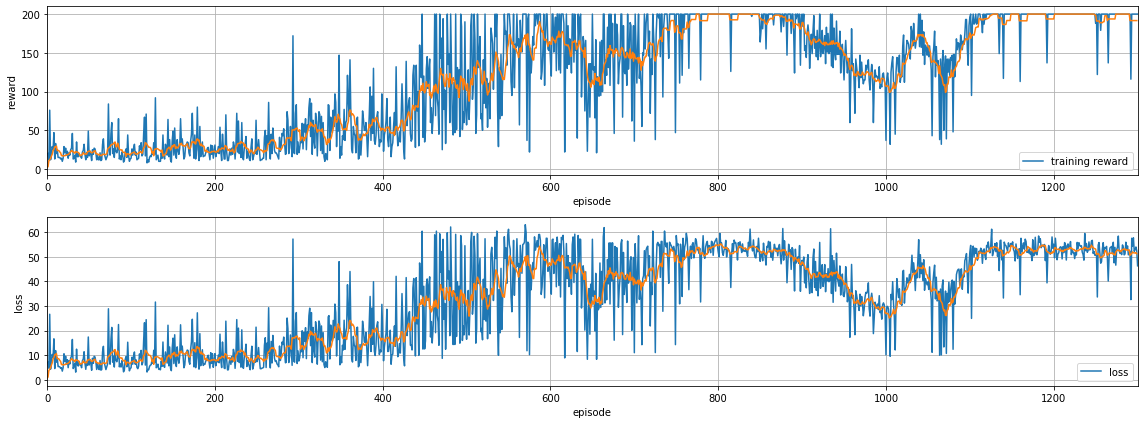

In [49]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [50]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
show_replay()

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

* *By increasing the number of `num_episodes`, at first I set it to 1000. I didn't see any improvement. Later, I try to high the number even more to 1.500 episodes, something that eventually improved `mean training reward`. Finally, the `num_episodes` is set to 2000 as it peaks maximum `mean training reward`.*

* *By adding another hidden layer (48 units) in the model, we try to make it more robust.*

* *After training the model w/ the extra layer, I feel like we should lower more the `num_episodes` to 1300. I will do that.*

* *I lower the learning rate some more, reaching this time 1e-4 * 9*

* *I found no practical change trying to play around the discount factor. I will leave it as was by default, at 1.0*

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

* *The total reward is the sum of the rewards. The answer is 5.*

* *The total future reward in each timestep is the total reward minus the cumulative sum of the list: [5, 5, 4, 3, 3, 2, 1, 0, 0, 0]*

* *The total discounted future reward is the list from 2) mutiplied by $\gamma^t$: [5, 4.5, 3.24, 2.187, 1.9683, 1.18098, 0.531441, 0, 0, 0]*

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

*During the validation, the weights are already updated from the previous step and since the policy is guaranteed to be at least as good as the previous one, the reward must be higher. Moreover, during training the action is sampled while on the validation step, the action is taken directly from the network. This, of course makes the deterministic action more effective when validating.*

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

*When the method decides which action to take, it chooses the `argmax` of the action and a draw from a uniform random distribution. This is the exploration-exploitation dilemma. If the draw is higher than the probability generated by the network, it will take another action, this is the exploring part. As the network is trained, it gets more confident of the actions it should take and therefore the probability of a certain action is high, the likelihood of this probability being smaller than a random draw becomes really small. This is the exploitation part.*

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

### Michael Nielsen book exercise of own choice

Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, c>0. 

Show that the behaviour of the network doesn't change.

**Answer:**

The output of a perceptron is defined as such:
$$ 
\text{output} = 
   \left\{
\begin{array}{lll}
      0 & \text{if} & wx+b \leq 0 \\
      1 & \text{if} & wx+b > 0 \\
\end{array} 
\right. 
$$
Where $w$ and $x$ is the weight and input and $b$ is the bias. Now the terms are multiplied by c>0:
$$ 
\Leftrightarrow \\
\text{output} = 
   \left\{
\begin{array}{lll}
      0 & \text{if} & c\left(wx+b\right) \leq 0 \\
      1 & \text{if} & c\left(wx+b\right) > 0 \\
\end{array} 
\right. \\
\Leftrightarrow \\
\text{output} = 
   \left\{
\begin{array}{lll}
      0 & \text{if} & wx+b \leq 0 \\
      1 & \text{if} & wx+b > 0 \\
\end{array} 
\right. 
$$

This more or less corresponds to stretching the numbers axis around zero, and thus it makes sense that the behaviour should remain the same, however if the constant is negative we flip the axis around and also the behaviour of the perceptron
